In [25]:
import pandas as pd
import numpy as np
import math
from scipy.spatial import distance_matrix

import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import seaborn as sns


In [26]:

df = pd.read_csv('THOR_FILTERED_CLEANED_IMPUTED_USA.csv', parse_dates=['MSNDATE'])

In [27]:
normalized = df[["MSNDATE", "LATITUDE", "LONGITUDE", "TONS_OF_HE"]]


In [28]:
normalized = df[["MSNDATE", "LATITUDE", "LONGITUDE"]]
startDate = pd.Timestamp('1942-07-04')
normalized["MSNDATE"] = normalized["MSNDATE"].apply(lambda x: (x - startDate).days)
print(normalized)


       MSNDATE  LATITUDE  LONGITUDE
0            8     48.13      11.58
1          109     49.63      -1.62
2          109     49.63      -1.62
3          109     49.63      -1.62
4          203     47.75      -3.35
...        ...       ...        ...
21338     1032     45.67      10.67
21339     1032     47.78      13.03
21340     1032     45.67      10.67
21341     1032     49.63      13.17
21342     1032     45.67      10.67

[21343 rows x 3 columns]


C:\Users\davie\AppData\Local\Temp\ipykernel_10480\3621489089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized["MSNDATE"] = normalized["MSNDATE"].apply(lambda x: (x - startDate).days)


In [29]:
scaler = MinMaxScaler()
scaler.fit(normalized)
scaled_data = scaler.transform(normalized)
scaled_data = pd.DataFrame(scaled_data, columns = ['MSNDATE', 'LATITUDE', 'LONGITUDE'])

In [30]:
scaled_data

MSNDATE  LATITUDE  LONGITUDE
0      0.000000  0.257458   0.015998
1      0.098633  0.278665   0.002865
2      0.098633  0.278665   0.002865
3      0.098633  0.278665   0.002865
4      0.190430  0.252085   0.001144
...         ...       ...        ...
21338  1.000000  0.222678   0.015092
21339  1.000000  0.252510   0.017440
21340  1.000000  0.222678   0.015092
21341  1.000000  0.278665   0.017579
21342  1.000000  0.222678   0.015092

[21343 rows x 3 columns]

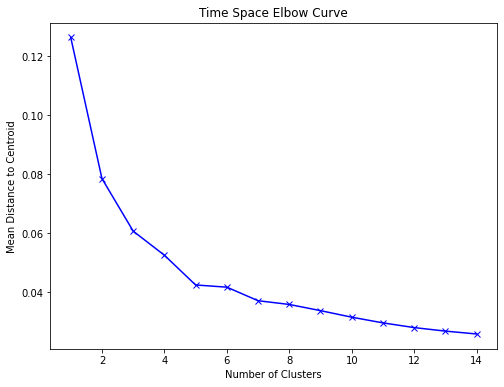

In [31]:
from scipy.spatial.distance import cdist

#data = normalized
data = scaled_data
MeanDist = list()
cluster = range(1, 15)

for i in cluster:
    kmeans = KMeans(n_clusters=i).fit(data)
    MeanDist.append(np.average(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)))    

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(cluster, MeanDist, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Distance to Centroid')
plt.title('Time Space Elbow Curve')
plt.show();

In [32]:
data

MSNDATE  LATITUDE  LONGITUDE
0      0.000000  0.257458   0.015998
1      0.098633  0.278665   0.002865
2      0.098633  0.278665   0.002865
3      0.098633  0.278665   0.002865
4      0.190430  0.252085   0.001144
...         ...       ...        ...
21338  1.000000  0.222678   0.015092
21339  1.000000  0.252510   0.017440
21340  1.000000  0.222678   0.015092
21341  1.000000  0.278665   0.017579
21342  1.000000  0.222678   0.015092

[21343 rows x 3 columns]

In [33]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in cluster]
K=5
kmeans[(K-1)]

df['clusterN'] = kmeans[(K-1)].predict(data)
df.index = data.index
df['MSNDATE'] = data['MSNDATE']
df['LATITUDE'] = data['LATITUDE']
df['LONGITUDE'] = data['LONGITUDE']

print(df['clusterN'].value_counts())
centers = np.array(kmeans[(K-1)].cluster_centers_)
print(centers)

3    6992
4    5431
1    5077
0    3000
2     843
Name: clusterN, dtype: int64
[[0.59619694 0.29314807 0.01876952]
 [0.83915417 0.28242183 0.01616511]
 [0.3622514  0.28233124 0.00940306]
 [0.7231247  0.27774883 0.01152225]
 [0.95408538 0.27341112 0.01593708]]


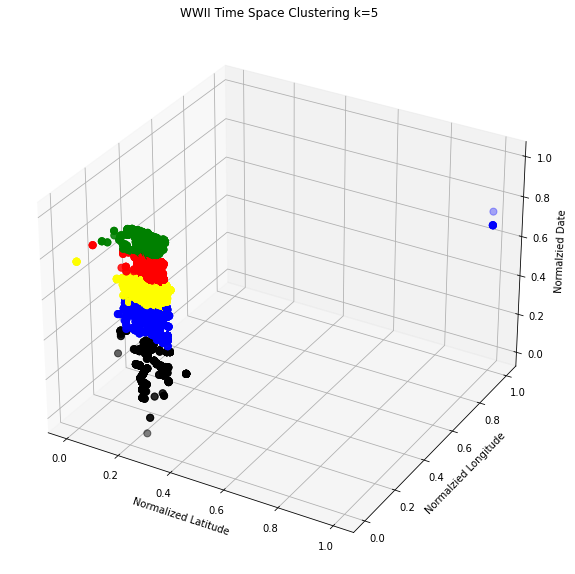

In [34]:
color = {0:'blue', 1:'red', 2:'black', 3:'yellow', 4:'green', 5:'purple'}
label_color = [color[l] for l in df['clusterN']]

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111,  projection='3d')

scatter = ax.scatter(df['LATITUDE'], df['LONGITUDE'], df['MSNDATE'], c =label_color, s=50)


ax.set_title('WWII Time Space Clustering k=' + str(K))
ax.set_xlabel('Normalized Latitude')
ax.set_ylabel('Normalzied Longitude')
ax.set_zlabel('Normalzied Date')
plt.show()

In [35]:
unscaled = scaler.inverse_transform(data)
unscaled=pd.DataFrame(unscaled, columns=["MSNDATE",	"LATITUDE",	"LONGITUDE"])
unscaled["cluster"] = df["clusterN"]
unscaled["MSNDATE"] = unscaled["MSNDATE"].astype(int)
unscaled["Date"] = unscaled["MSNDATE"].apply(lambda x: str((startDate + pd.DateOffset(x)).date()))
unscaled["Tons"] = df["TONS_OF_HE"]

In [36]:
#Using pydeck
import pydeck as pdk
layer = pdk.Layer(
    'ScatterplotLayer',
    unscaled,
    pickable=True,
    opacity=0.5,
    stroked=True,
    filled=True,
    radius_min_pixels=2,
    line_width_min_pixels=1,
    get_position=["LONGITUDE", "LATITUDE","MSNDATE*1500"],
    get_fill_color='[cluster > 1? 100: cluster ==1 ? 50: 255, cluster <3 ? cluster*40: 140, cluster >2 ? cluster*50: 140]',
    get_line_color=[0, 0, 0],
)
view_state = pdk.ViewState(latitude=50.13, longitude=11.58, zoom=3, bearing=0, pitch=0)

r = pdk.Deck(map_style="light",layers=[layer], initial_view_state=view_state, tooltip={"text": "LatLong: {LATITUDE} {LONGITUDE}\nDate = {Date}\nCluster: {cluster}\nTons Dropped: {Tons}"})
r.to_html("scatterplot_layer.html")

In [37]:
layer = pdk.Layer(
    'ScatterplotLayer',
    unscaled,
    pickable=True,
    opacity=0.5,
    stroked=True,
    filled=True,
    radius_min_pixels=1,
    get_radius="Tons*300",
    line_width_min_pixels=1,
    get_position=["LONGITUDE", "LATITUDE","MSNDATE*1500"],
    get_fill_color='[cluster > 1? 100: cluster ==1 ? 50: 255, cluster <3 ? cluster*40: 140, cluster >2 ? cluster*50: 140]',
    get_line_color=[0, 0, 0],
)
view_state = pdk.ViewState(latitude=50.13, longitude=11.58, zoom=3, bearing=0, pitch=0)

r = pdk.Deck(map_style="light",layers=[layer], initial_view_state=view_state, tooltip={"text": "LatLong: {LATITUDE} {LONGITUDE}\nDate = {Date}\nCluster: {cluster}\nTons Dropped: {Tons}"})
r.to_html("scatterplot_layer_Tons_Drop.html")

In [38]:
#get total bombs per cluster
totalBombs = unscaled.groupby("cluster").agg("sum")
StartDate = unscaled.groupby("cluster").agg("min")
EndDate = unscaled.groupby("cluster").agg("max")
Totals = pd.DataFrame()
Totals["Start"] = StartDate["Date"]
Totals["End"] = EndDate["Date"]
Totals["Start"] = pd.to_datetime(Totals["Start"])
Totals["End"] = pd.to_datetime(Totals["End"])
Totals["Tons of Bombs"] = totalBombs["Tons"]
Totals["Tons per Day"] = Totals["Tons of Bombs"]/((Totals["End"]-Totals["Start"]).dt.days)
Totals["Days"] = ((Totals["End"]-Totals["Start"]).dt.days)
Totals

Start        End  Tons of Bombs  Tons per Day  Days
cluster                                                         
0       1943-11-13 1944-08-13        90828.0    331.489051   274
1       1944-09-19 1945-01-17       112508.0    937.566667   120
2       1942-07-12 1943-11-14        16371.0     33.410204   490
3       1944-05-08 1944-09-14       193838.0   1502.620155   129
4       1945-01-13 1945-05-01       139851.0   1294.916667   108

In [39]:
unscaled = unscaled.sort_values("cluster")
unscaled.to_csv("ClusterMembership.csv")
